In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

file = tf.keras.utils
pd.set_option('display.max_columns',40)
pd.set_option('display.max_rows',20)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !importent; }</style>"))

In [12]:
df_data_org = pd.read_csv(r'C:\Users\Susara\Documents\ANN\H1.csv' )
df_data_org.tail(10)
df_data_org.head(10)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,0,14,2015,July,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,0,0,2015,July,27,1,0,2,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NULL,NULL,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,0,9,2015,July,27,1,0,2,2,0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303,NULL,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,1,85,2015,July,27,1,0,3,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,NULL,0,Transient,82.0,0,1,Canceled,2015-05-06
9,1,75,2015,July,27,1,0,3,2,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,15,NULL,0,Transient,105.5,0,0,Canceled,2015-04-22


In [3]:
df_data_org = df_data_org.drop(columns=['IsCanceled'], axis=0) 

In [4]:
df_data_org = df_data_org.drop(columns=['StaysInWeekendNights'], axis=0) 

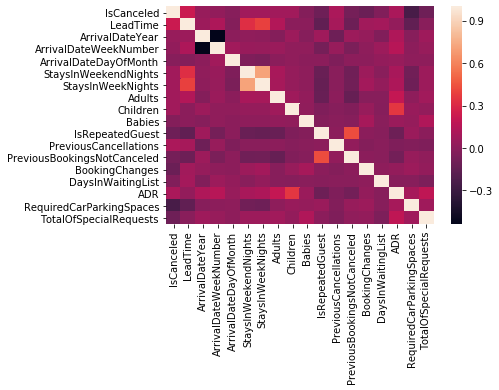

In [3]:
import matplotlib as plt
corr = df_data_org.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [7]:
df_data_org['StaysInWeekNights'].corr( df_data_org["StaysInWeekendNights"])

0.7168893969144619

In [5]:
df_data_org['PreviousBookingsNotCanceled'].corr( df_data_org["IsRepeatedGuest"])

0.4279600623256673

In [5]:
df_data_org.columns

Index(['LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInWeekNights',
       'Adults', 'Children', 'Babies', 'Meal', 'Country', 'MarketSegment',
       'DistributionChannel', 'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'Company',
       'DaysInWaitingList', 'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate'],
      dtype='object')

In [6]:
df_data_org.RequiredCarParkingSpaces.unique()

array([0, 1, 2, 8, 3], dtype=int64)

In [7]:

train, test = train_test_split(df_data_org, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')
#df_data_org['MarketSegment'] = pd.to_numeric(df_data_org['MarketSegment'])
#df_data_org.head()


25638 train examples
6410 validation examples
8012 test examples


In [8]:
def df_to_dataset(df_data_org, shuffle=True, batch_size=32):
  df_data_org = df_data_org.copy()
  df_data_org = df_data_org.dropna()
  labels = df_data_org.pop('ADR')
  ds = tf.data.Dataset.from_tensor_slices((dict(df_data_org), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df_data_org))
  ds = ds.batch(batch_size)
  return ds

In [9]:
batch_size = 64 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [10]:
example_batch = next(iter(train_ds))[0]

In [11]:
feature_columns = []

# numeric cols
for header in ['LeadTime','Adults','Children','Babies','StaysInWeekNights','BookingChanges','TotalOfSpecialRequests', 
               'RequiredCarParkingSpaces','PreviousBookingsNotCanceled','PreviousCancellations','ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth']:
  feature_columns.append(feature_column.numeric_column(header))

MarketSegment = feature_column.categorical_column_with_vocabulary_list(
      'MarketSegment', ['Direct', 'Corporate', 'Online TA', 'Offline TA/TO','Complementary','Groups'])
MarketSegment_one_hot = feature_column.indicator_column(MarketSegment)
feature_columns.append(MarketSegment_one_hot)

ReservationStatus = feature_column.categorical_column_with_vocabulary_list(
      'ReservationStatus', ['Check-Out', 'Canceled', 'No-Show'])
ReservationStatus_one_hot = feature_column.indicator_column(ReservationStatus)
feature_columns.append(ReservationStatus_one_hot)


DepositType = feature_column.categorical_column_with_vocabulary_list(
      'DepositType', ['No Deposit     ', 'Refundable     ', 'Non Refund     '])
DepositType_one_hot = feature_column.indicator_column(DepositType)
feature_columns.append(DepositType_one_hot)



CustomerType = feature_column.categorical_column_with_vocabulary_list(
      'CustomerType', ['Transient', 'Contract', 'Transient-Party', 'Group'])
CustomerType_one_hot = feature_column.indicator_column(CustomerType)
feature_columns.append(CustomerType_one_hot)

Meal = feature_column.categorical_column_with_vocabulary_list(
      'Meal', ['BB', 'FB', 'HB', 'SC', 'Undefined'])
Meal_one_hot = feature_column.indicator_column(Meal)
feature_columns.append(Meal_one_hot)

ArrivalDateMonth = feature_column.categorical_column_with_vocabulary_list(
      'ArrivalDateMonth', ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
ArrivalDateMonth_one_hot = feature_column.indicator_column(ArrivalDateMonth)
feature_columns.append(ArrivalDateMonth_one_hot)

ReservedRoomType = feature_column.categorical_column_with_vocabulary_list(
      'ReservedRoomType', ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'P', 'L'])
ReservedRoomType_one_hot = feature_column.indicator_column(ReservedRoomType)
feature_columns.append(ReservedRoomType_one_hot)

#Country = feature_column.categorical_column_with_vocabulary_list(
#      'Country', ['PRT', 'GBR', 'USA', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'OMN',
 #      'ARG', 'POL', 'DEU', 'BEL', 'CHE', 'CN', 'GRC', 'ITA', 'NLD',
 #      'DNK', 'RUS', 'SWE', 'AUS', 'EST', 'CZE', 'BRA', 'FIN', 'MOZ',
#       'BWA', 'LUX', 'SVN', 'ALB', 'IND', 'CHN', 'MEX', 'MAR', 'UKR',
 #      'SMR', 'LVA', 'PRI', 'SRB', 'CHL', 'AUT', 'BLR', 'LTU', 'TUR',
#       'ZAF', 'AGO', 'ISR', 'CYM', 'ZMB', 'CPV', 'ZWE', 'DZA', 'KOR',
#       'CRI', 'HUN', 'ARE', 'TUN', 'JAM', 'HRV', 'HKG', 'IRN', 'GEO',
#       'AND', 'GIB', 'URY', 'JEY', 'CAF', 'CYP', 'COL', 'GGY', 'KWT',
 #      'NGA', 'MDV', 'VEN', 'SVK', 'FJI', 'KAZ', 'PAK', 'IDN', 'LBN',
#       'PHL', 'SEN', 'SYC', 'AZE', 'BHR', 'NZL', 'THA', 'DOM', 'MKD',
#       'MYS', 'ARM', 'JPN', 'LKA', 'CUB', 'CMR', 'BIH', 'MUS', 'COM',
#       'SUR', 'UGA', 'BGR', 'CIV', 'JOR', 'SYR', 'SGP', 'BDI', 'SAU',
#       'VNM', 'PLW', 'QAT', 'EGY', 'PER', 'MLT', 'MWI', 'ECU', 'MDG',
#       'ISL', 'UZB', 'NPL', 'BHS', 'MAC', 'TGO', 'TWN', 'DJI'])
#Country_one_hot = feature_column.indicator_column(Country)
#feature_columns.append(Country_one_hot)

In [12]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [13]:
batch_size = 128
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from datetime import datetime

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(32, activation='relu' , kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None) ),
# keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
 # layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
# layers.Dropout(0.2),
  layers.Dense(1)
])

#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)

logdir="logs" 
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


#history = model.fit(train_ds, validation_data=val_ds,epochs=100 , callbacks=[es])
history = model.fit(train_ds, validation_data=val_ds,epochs=100 , callbacks=[tensorboard_callback])


import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/100
      1/Unknown - 4s 4s/step - loss: 12052.5273 - accuracy: 0.0078WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.156245). Check your callbacks.
198/198 [==============================] - 12s 58ms/step - loss: 5263.4719 - accuracy: 2.7623e-04 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
198/198 [==============================] - 5s 24ms/step - loss: 2667.8329 - accuracy: 0.0000e+00 - val_loss: 2087.5088 - val_accuracy: 0.0000e+00
Epoch 3/100
198/198 [==============================] - 5s 25ms/step - loss: 1597.6475 - accuracy: 0.0000e+00 - val_loss: 1398.1402 - val_accuracy: 0.0000e+00
Epoch 4/100
198/198 [==============================] - 5s 24ms/step - loss: 1180.1949 - accuracy: 0.0000e+00 - val_loss: 1250.8745 - val_accuracy: 0.0000e+00
Epoch 5/100
116/198 [================>.............] - ETA: 1s - loss: 1075.9855 - accuracy: 1.3587e-04

KeyboardInterrupt: 

In [8]:
%reload_ext tensorboard

In [10]:
tensorboard --logdir /logs/train


Reusing TensorBoard on port 6006 (pid 696), started 0:41:58 ago. (Use '!kill 696' to kill it.)